<a href="https://colab.research.google.com/github/Shonn-Li/CS484-final-project/blob/main/CS484_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries
import random
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
from typing import OrderedDict
from torch.utils.data import DataLoader, random_split, Subset, Dataset, ConcatDataset
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()


### Step 1: Prepare data
We will use CIFAR10 dataset.

In [ ]:
caltech256_all = datasets.Caltech256(root="./data", download=True, transform=transforms.ToTensor())

def indexFilter(target, dataset):
  target_indices = []
  remains = []
  for i in range(len(dataset)):
    img, label = dataset[i]
    if img.size(0) == 3 and label == target:
      target_indices.append(i)
    elif img.size(0) == 3:
      remains.append(i)
  return target_indices, remains


# class for applying transformations
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None, target=None):
        self.dataset = dataset
        self.transform = transform
        self.target = target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
          image = self.transform(image)
        if self.target:
          return image, 1 if (label == self.target) else 0
        return image, label

# img transform
norms = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
trainTrans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(*norms)
])



Files already downloaded and verified


In [ ]:
# get target class data
target_class = 30 # define the class we want to recognize
target_indices, remains = indexFilter(target_class, caltech256_all)
target_dataset = Subset(caltech256_all, target_indices)
print(f"number of targets: {len(target_dataset)}")

# draw samples from the remaining data
subset_size = len(target_dataset) * 5
random_indices = random.sample(remains, subset_size)
remain_dataset = Subset(caltech256_all, random_indices)

# combine target and remain, redefine labels
caltech256_filtered = ConcatDataset([target_dataset, remain_dataset])
caltech256 = TransformDataset(caltech256_filtered, transform=trainTrans, target=target_class)


number of targets: 89


In [ ]:
print(f"processed dataset size: {len(caltech256)}")

processed dataset size: 534


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image label: 1
torch.Size([3, 224, 224])


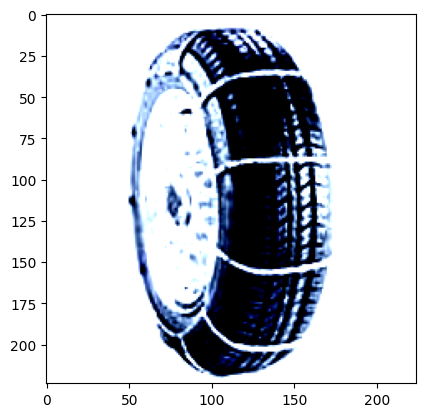

In [ ]:
img, label = caltech256[50]
print(f"image label: {label}")
plt.figure()
plt.imshow(torch.permute(img, (1, 2, 0)))
print(img.shape)

### Step 2: Define Network

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MyModel, self).__init__()

        # extract vgg19 feature layer
        vgg19 = models.vgg19(weights='DEFAULT')
        self.vgg19Feat = vgg19.features[:28] # result in 512x14x14
        for param in self.vgg19Feat.parameters():
            param.requires_grad = False

        # additional conv layer & average pooling
        self.process = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('pool', nn.AdaptiveAvgPool2d((1, 1))),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(1024, num_classes))
        ]))


    def forward(self, x):
        x = self.vgg19Feat(x)
        x = self.process(x)

        return x

### Step 3: Training

In [ ]:
# training function
def trainLoop(model, criterion, optimizer, dataloader, max_epoch):
    losses = []
    accuracies = []
    model.train()
    for epoch in range(max_epoch):
        epoch_loss = 0
        epoch_correct = 0
        dataCount = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(dim=1)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            dataCount += images.size(0)

            epoch_correct += torch.eq(preds, labels).sum().item()

            loss.backward()
            optimizer.step()

        # gather loss
        epoch_avg_loss = epoch_loss / dataCount
        epoch_acc = epoch_correct / dataCount
        losses.append(epoch_avg_loss)
        accuracies.append(epoch_acc)
        print(f"Epoch {epoch + 1}， loss is {epoch_avg_loss:.3f}, accuracy is {epoch_acc:.3f}")

    return losses, accuracies

In [ ]:
# split data into test and training sets
train_size = int(0.8 * len(caltech256))
test_size = len(caltech256) - train_size
train_dataset, test_dataset = random_split(caltech256, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# perform training
model = MyModel().to(device)
criterion = nn.CrossEntropyLoss()
parameters = [{'params': model.process.parameters()}]
optimizer = optim.Adam(parameters, lr=0.001)
max_epoch=5
train_loss, train_acc = trainLoop(model, criterion, optimizer, train_loader,  max_epoch)

Epoch 1， loss is 0.179, accuracy is 0.745
Epoch 2， loss is 0.029, accuracy is 0.883
Epoch 3， loss is 0.008, accuracy is 0.932
Epoch 4， loss is 0.004, accuracy is 0.970
Epoch 5， loss is 0.003, accuracy is 0.974


### Step 4: Create CAM

In [ ]:
class CAM(nn.Module):
  def __init__(self, model):
    super(CAM, self).__init__()
    self.weights = list(model.process.linear.parameters())[0]
    self.feature_layers = nn.Sequential(model.vgg19Feat, model.process.conv)

    for params in self.feature_layers.parameters():
      params.requires_grad = False

  def forward(self, imgs, categories):
    feat_weights = self.weights[categories].unsqueeze(-1).unsqueeze(-1)
    feat_maps= self.feature_layers(imgs)

    cam = torch.sum(feat_weights * feat_maps, dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, imgs.shape[2:], mode='bilinear', align_corners=False)

    cam = cam - cam.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
    cam = cam / cam.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0]

    return cam




In [ ]:
def createCAM(model, dataset, demoTransform, inputTransform, target=target_class,
              CustomTransform=TransformDataset, batch_size=32):
  camModel = CAM(model)
  inputData = CustomTransform(dataset, inputTransform)
  demoData = CustomTransform(dataset, demoTransform)
  inputLoader = DataLoader(inputData, batch_size, shuffle=False)
  demoLoader = DataLoader(demoData, batch_size, shuffle=False)

  heatmaps = []
  demoImages = []

  with torch.no_grad():
    for (inputImgs, labels), (demoImgs, _) in zip(inputLoader, demoLoader):
      heatImg = camModel(inputImgs.to(device), labels.to(device))

      heatmaps.append(heatImg.cpu())
      demoImages.append(demoImgs)

    resultHeatMaps = torch.cat(heatmaps, dim=0)
    resultDemoImages = torch.cat(demoImages, dim=0)

    return resultHeatMaps, resultDemoImages



In [ ]:
demoTrans = transforms.Compose(
    [transforms.Resize((224, 224))]
)
inputTrans = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.Normalize(*norms)]
)
indicies = [i for i in range(40, 50, 1)]
caltech256_sub = Subset(caltech256, indicies)
heatMaps, oriImgs = createCAM(model, caltech256_sub, demoTrans, inputTrans)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
heatMaps.shape

torch.Size([10, 1, 224, 224])

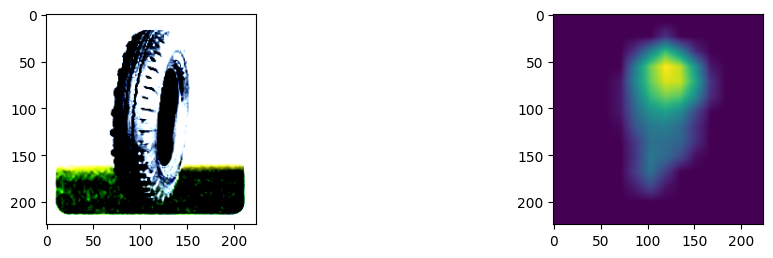

In [ ]:
idx = 5
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(oriImgs[idx].permute(1, 2, 0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(heatMaps[idx].permute(1, 2, 0))

### TODO
- Write function to generate heat map for correctly identified picture
- Implement "object localization"


In [2]:
%pip install d2l==1.0.3

In [3]:
from d2l import torch as d2l

### Step 5: create single shot multibox detection model (SSD)

We will slightly modify the SSD model learned from [chapter 14.7 of Dive into Deep Learning](https://d2l.ai/chapter_computer-vision/ssd.html)

The overall structure of SSD is shown in the picture (from Dive into Deep Learning). We will replace the base network with the feature layers of VGG19, which is also used to generate heatmap.
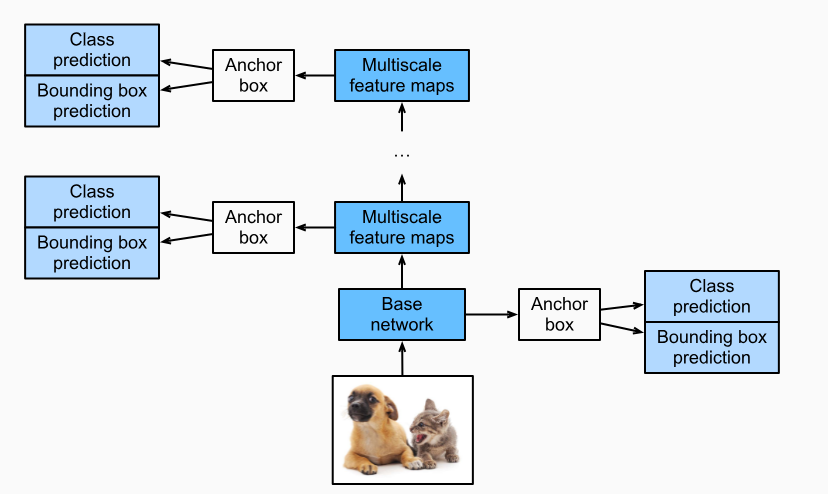

In [4]:
# code reference (https://d2l.ai/chapter_computer-vision/ssd.html)

# generate class prediction layer
# note: the prediction output has the same w, h as the input
# it predict the class of all anchor boxes centered at each pixel
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)


# generate anchor box offset prediction
# note: the anchor box offset prediction predict each of the 4 offset
# of the anchor box centered at each pixel. It doesn't change the h, w of image
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)


# the following function concatenate predction result from different scale
# feature maps into 2d tensor shape (batch_size, combined_features), to compute
# final outcome more efficiently
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)


# the following function rescale the feature map to half of its input size
# generate feature map for next scale class prediction and anchor boxes
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)


# the following function create the base net that uses first 26 feature net
# in the VGG19.
# for input image shape 256x256, the output shape is 32x32
# for input shape 224x224, its output shape is 28x28
# channel 3 -> 512
def base_net():
  vgg19 = models.vgg19(weights='DEFAULT')
  feature_layers = vgg19.features[:26]  # Take the first 28 layers
  for param in feature_layers.parameters():
    param.requires_grad = False # freeze layer

  return feature_layers

# the following generate different layers
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(512, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk


# the following function apply the network to generate anchors, class predictions
# at each scale
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)


# the following define the size of anchor boxes and their ratios at each scale
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [5]:
# define network
class VGGSSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(VGGSSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [512, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

### step 7: train VGGSSD

In [7]:
# load data
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

# create model, optimizer and loss function
vggssd = VGGSSD(num_classes=1).to(device)
vggssd_parameters = list(vggssd.parameters())[1:] # exclude vgg feature layer
vggssd_optimizer = torch.optim.SGD(vggssd_parameters, lr=0.2, weight_decay=5e-4)

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

# code reference (https://d2l.ai/chapter_computer-vision/ssd.html)
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

# compute accuracy
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

read 1000 training examples
read 100 validation examples


class err 3.89e-03, bbox mae 2.04e+02
3446.0 examples/sec on cuda


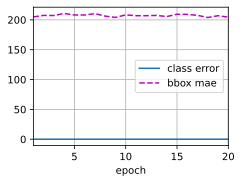

In [9]:
# code reference (https://d2l.ai/chapter_computer-vision/ssd.html)
def train_vggssd(model, optimizer, dataloader, num_epochs=20):
  timer = d2l.Timer()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                          legend=['class error', 'bbox mae'])
  for epoch in range(num_epochs):
      metric = d2l.Accumulator(4)
      vggssd.train()
      for features, target in dataloader:
          timer.start()
          optimizer.zero_grad()
          X, Y = features.to(device), target.to(device)
          anchors, cls_preds, bbox_preds = vggssd(X)
          bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
          l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                        bbox_masks)
          l.mean().backward()
          optimizer.step()
          metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                    bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                    bbox_labels.numel())
      cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
      animator.add(epoch + 1, (cls_err, bbox_mae))

  print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
  print(f'{len(dataloader.dataset) / timer.stop():.1f} examples/sec on '
        f'{str(device)}')


train_vggssd(vggssd, vggssd_optimizer, train_iter)

In [10]:
# model shape test
class CustomVGG(nn.Module):
    def __init__(self):
        super(CustomVGG, self).__init__()
        vgg19 = models.vgg19(weights='DEFAULT')
        self.features = vgg19.features[:26]  # Take the first 28 layers

    def forward(self, x):
        x = self.features(x)
        return x

# Create the model
model = CustomVGG()

# Dummy input tensor
input_tensor = torch.zeros((2, 3, 256, 256))

# Forward pass
output_tensor = model(input_tensor)

print(output_tensor.shape)

torch.Size([2, 512, 32, 32])
